In [30]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from pycaret.time_series import *
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import DMatrix

In [42]:
import torch
print(torch.__path__)
print(torch.__version__)
print(torch.version.cuda)
print("CUDA Available:", torch.cuda.is_available())
print("PyTorch CUDA Version:", torch.version.cuda)
print("Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")


['c:\\Users\\woutp\\Documents\\3AI\\Cloud AI\\Project\\CloudAI\\project_venv\\lib\\site-packages\\torch']
2.5.1+cpu
None
CUDA Available: False
PyTorch CUDA Version: None
Device Name: No GPU detected


In [97]:
#Subset
data = pd.read_csv(".\\price_paid_records.csv")
data.columns = data.columns.str.lower()
data = data.drop(columns=['transaction unique identifier', 'property type', 'old/new', 'duration', 'town/city', 'district', 'county', 'ppdcategory type', 'record status - monthly file only'])
data = data.dropna()  # Handle missing values, if any
data = data.sort_values(by='date of transfer')
# Sum of prices for each day
data['date of transfer'] = pd.to_datetime(data['date of transfer'])
data['yearmonth'] =  data["date of transfer"].dt.year.astype(str) + '-' + data["date of transfer"].dt.month.astype(str).str.zfill(2)
data = data.groupby('yearmonth')['price'].sum().reset_index()
data

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [83]:
subset_data = data.head(215)
subset_file_path = 'subset_80.csv'
subset_data.to_csv(subset_file_path, index=False)


#test
test_data = data.iloc[215:]
test_file_path = 'test_20.csv'
test_data.to_csv(test_file_path, index=False)

In [119]:
data = pd.read_csv(".\\test_20.csv")
data

,yearmonth,price
0,2012-12,13467104028
1,2013-01,10677728282
2,2013-02,10656533732
3,2013-03,12940255818
4,2013-04,12468308389
5,2013-05,15859143526
6,2013-06,16322141867
7,2013-07,19353399006
8,2013-08,20939669718
9,2013-09,19390192591


In [ ]:
# data['price_log'] = np.log1p(data['price'])
# data

In [ ]:
# data['year'] = data['date of transfer'].dt.year
# data['month'] = data['date of transfer'].dt.month
# data['quarter'] = data['date of transfer'].dt.quarter
# data

In [ ]:
# Q1 = data['price'].quantile(0.25)
# Q3 = data['price'].quantile(0.75)
# IQR = Q3 - Q1
# data = data[(data['price'] >= Q1 - 1.5 * IQR) & (data['price'] <= Q3 + 1.5 * IQR)]
# data

In [ ]:
# data[['price']] = StandardScaler().fit_transform(data[['price']])
# data

In [ ]:
# columns_to_encode = ['town/city', 'district', 'county', 'old/new', 'property type', 'duration', 'ppdcategory type']
# le = LabelEncoder()
# for col in columns_to_encode:
#     data[col] = le.fit_transform(data[col])
# data

,transaction unique identifier,price,date of transfer,property type,old/new,duration,town/city,district,county,ppdcategory type,record status - monthly file only
0,{81B82214-7FBC-4129-9F6B-4956B4A663AD},25000,1995-08-18,3,0,0,664,263,38,0,A
1,{8046EC72-1466-42D6-A753-4956BF7CD8A2},42500,1995-08-09,2,0,0,383,376,94,0,A
2,{278D581A-5BF3-4FCE-AF62-4956D87691E6},45000,1995-06-30,3,0,0,439,309,81,0,A
3,{1D861C06-A416-4865-973C-4956DB12CD12},43150,1995-11-24,3,0,0,75,240,2,0,A
4,{DD8645FD-A815-43A6-A7BA-4956E58F1874},18899,1995-06-23,2,0,0,947,200,103,0,A
...,...,...,...,...,...,...,...,...,...,...,...
24995,{435651DE-F62B-4F33-B81D-178C3E9F6FDF},53500,1995-07-11,0,0,0,303,191,63,0,A
24996,{41DB8CBB-784C-4A06-A3A4-25D2CA1104F3},46740,1995-09-29,2,1,0,915,305,101,0,A
24997,{D40E45BA-894F-4190-8A5E-25D2D1BFCC26},115000,1995-06-30,0,0,0,864,352,89,0,A
24998,{00B2D6E2-CFAE-4E16-A701-25D2E8267D9C},240000,1995-04-03,3,0,0,553,197,37,0,A


In [120]:
data

,yearmonth,price
0,2012-12,13467104028
1,2013-01,10677728282
2,2013-02,10656533732
3,2013-03,12940255818
4,2013-04,12468308389
5,2013-05,15859143526
6,2013-06,16322141867
7,2013-07,19353399006
8,2013-08,20939669718
9,2013-09,19390192591


In [121]:
# data['date of transfer'] = pd.to_datetime(data['date of transfer'])
# data = data.sort_values(by='date of transfer')

# data['yearmonth'] =  data["date of transfer"].dt.year.astype(str) + '-' + data["date of transfer"].dt.month.astype(str).str.zfill(2)
# data = data.groupby('yearmonth')['price'].sum().reset_index()
data['yearmonth'] = pd.to_datetime(data['yearmonth'])
data['year'] = data['yearmonth'].dt.year
data['month'] = data['yearmonth'].dt.month
data['quarter'] = data['yearmonth'].dt.quarter
# data['day'] = data['date of transfer'].dt.day
# data['day'] = data['date of transfer'].dt.day
# data['day of week'] = data['date of transfer'].dt.dayofweek  # 0 = Monday, 6 = Sunday
# data['is weekend'] = (data['date of transfer'].dt.weekday >= 5).astype(int)  # Saturday or Sunday

# numerical_cols = ['year', 'month', 'day', 'day of week', 'quarter', 'is weekend']
# scaler = StandardScaler()
# data[numerical_cols] = scaler.fit_transform(data[numerical_cols])
data

,yearmonth,price,year,month,quarter
0,2012-12-01,13467104028,2012,12,4
1,2013-01-01,10677728282,2013,1,1
2,2013-02-01,10656533732,2013,2,1
3,2013-03-01,12940255818,2013,3,1
4,2013-04-01,12468308389,2013,4,2
5,2013-05-01,15859143526,2013,5,2
6,2013-06-01,16322141867,2013,6,2
7,2013-07-01,19353399006,2013,7,3
8,2013-08-01,20939669718,2013,8,3
9,2013-09-01,19390192591,2013,9,3


In [ ]:
# train_data, test_data = train_test_split(data, test_size=0.2, random_state=123)

In [ ]:
# cat_features = ['property type', 'old/new', 'duration', 'town/city', 'district', 'county', 'ppdcategory type']

In [122]:
# Load the test data
# test_data = pd.read_csv("test_6251.csv")
# test_data.columns = test_data.columns.str.lower()
test_data = data.copy()
test_data = test_data.drop(columns=['price'])
test_data['yearmonth'] = test_data["yearmonth"].astype("category")


# Load the XGBoost model
model_path = "xgboost-model"
model = xgb.Booster()
model.load_model(model_path)
print("Model loaded successfully.")

# Convert to DMatrix
dtest = DMatrix(test_data, enable_categorical=True)

# Predict prices
predictions = model.predict(dtest)

# Output predictions
print(predictions)
predictions = [float(p) for p in predictions]
print(predictions)

# True labels
true_labels = data["price"].astype(float).values

Model loaded successfully.
[4.9883331e+09 3.4434711e+09 3.3513324e+09 5.0285450e+09 3.8480282e+09
 4.5786199e+09 5.2077670e+09 4.6640517e+09 5.2796134e+09 4.6493292e+09
 4.2343539e+09 4.7157565e+09 4.9883331e+09 3.4434711e+09 3.3513324e+09
 5.0285450e+09 3.8480282e+09 4.5786199e+09 5.2077670e+09 4.6640517e+09
 5.2796134e+09 4.6493292e+09 4.2343539e+09 4.7157565e+09 4.9883331e+09
 3.4434711e+09 3.3513324e+09 5.0285450e+09 3.8480282e+09 4.5786199e+09
 5.2077670e+09 4.6640517e+09 5.2796134e+09 4.6493292e+09 4.2343539e+09
 4.7157565e+09 4.9883331e+09 3.4434711e+09 3.3513324e+09 5.0285450e+09
 3.8480282e+09 4.5786199e+09 5.2077670e+09 4.6640517e+09 5.2796134e+09
 4.6493292e+09 4.2343539e+09 4.7157565e+09 4.9883331e+09 3.4434711e+09
 3.3513324e+09 5.0285450e+09 3.8480282e+09 4.5786199e+09 5.2077670e+09]
[4988333056.0, 3443471104.0, 3351332352.0, 5028545024.0, 3848028160.0, 4578619904.0, 5207767040.0, 4664051712.0, 5279613440.0, 4649329152.0, 4234353920.0, 4715756544.0, 4988333056.0, 34434711

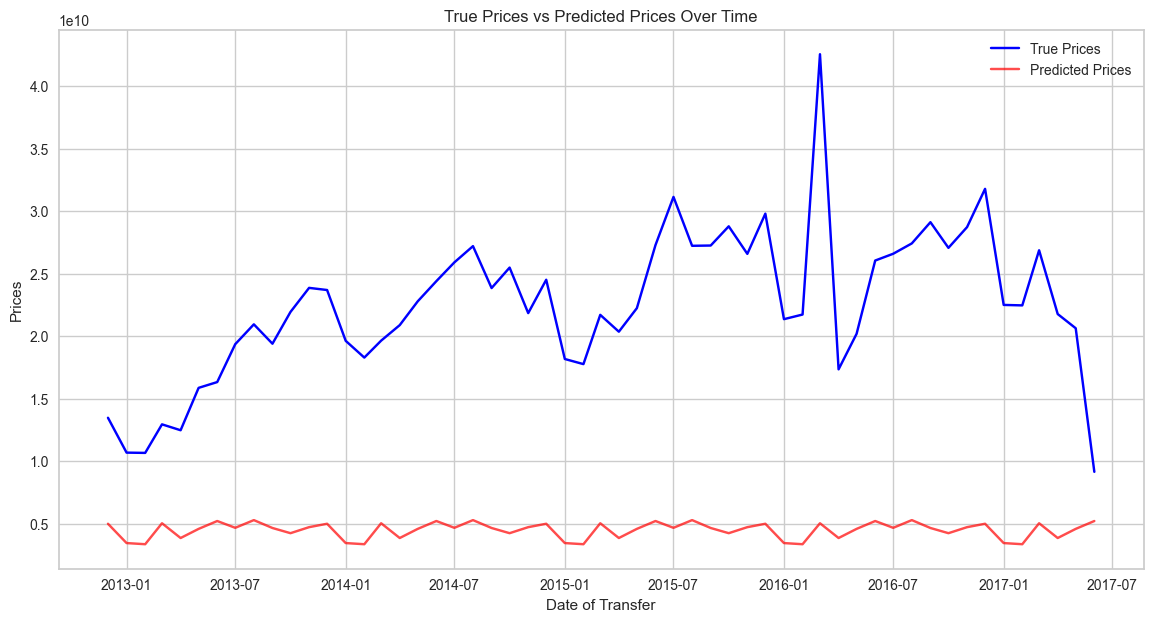

In [123]:
# Assuming 'date of transfer' column is available in test_data
data_graph = data
data_graph.columns = data_graph.columns.str.lower()
data_graph['yearmonth'] = pd.to_datetime(data_graph['yearmonth'])

plt.figure(figsize=(14, 7))
plt.plot(data_graph['yearmonth'], true_labels, label='True Prices', color='blue')
plt.plot(data_graph['yearmonth'], predictions, label='Predicted Prices', color='red', alpha=0.7)
plt.xlabel('Date of Transfer')
plt.ylabel('Prices')
plt.title('True Prices vs Predicted Prices Over Time')
plt.legend()
plt.show()

In [10]:
# Define features including time-based features
time_based_features = cat_features + ['year', 'month', 'day']

X_test = test_data[time_based_features]
y_test = test_data['price']

# Train the model using a Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(train_data[time_based_features], train_data['price'])
y_pred_rf = rf_model.predict(X_test)

# Calculate Mean Squared Error
rf_mse = mean_squared_error(y_test, y_pred_rf)
print("Random Forest Model MSE:", rf_mse)

# Calculate Accuracy
# Convert predictions to binary outcomes
y_pred_rf_binary = [1 if pred >= 0.5 else 0 for pred in y_pred_rf]
rf_accuracy = accuracy_score(y_test, y_pred_rf_binary)
print("Random Forest Model Accuracy:", rf_accuracy)

NameError: name 'cat_features' is not defined